# BP_Prediction3: PPG+ECG 1D CNN Regression (MAT v7.3 HDF5)
This notebook mirrors BP_Prediction2, but uses both PPG and ECG as a 2-channel input.
- Default training source: p008141.mat
- Targets: SegSBP, SegDBP
- Folds: 5 folds, each 400 segments (300 train / 50 val / 50 test)
- Reports: per-fold MAE/RMSE for SBP/DBP + mean/std across folds
- Optional cross-subject test on p044036.mat


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import h5py

plt.style.use('seaborn-v0_8-whitegrid')

def _resolve_ref(file: h5py.File, ref):
    value = file[ref][()]
    array = np.array(value)
    if array.dtype.kind in {'S','U'}:
        flat = array.ravel().astype(str)
        return ''.join(flat)
    array = np.squeeze(array)
    if isinstance(array, np.ndarray) and array.dtype.kind in {'i','u'} and array.size > 1:
        return ''.join(chr(int(x)) for x in array)
    if isinstance(array, np.ndarray) and array.size == 1:
        return array.item()
    return array

def extract_scalar_table(h5_path: str, columns: list) -> pd.DataFrame:
    records = {col: [] for col in columns}
    with h5py.File(h5_path, 'r') as f:
        subj = f['Subj_Wins']
        for col in columns:
            ds = subj[col]
            row = ds[0] if ds.ndim > 1 else ds[:]
            for ref in row:
                records[col].append(_resolve_ref(f, ref))
    return pd.DataFrame(records)

def extract_waveform_matrix(h5_path: str, key: str) -> np.ndarray:
    arrays = []
    with h5py.File(h5_path, 'r') as f:
        ds = f['Subj_Wins'][key][0]
        for ref in ds:
            waveform = np.array(f[ref][()], dtype=np.float32).ravel()
            arrays.append(waveform)
    lengths = {arr.shape[0] for arr in arrays}
    if len(lengths) != 1:
        raise ValueError(f'Waveforms have inconsistent lengths for {key}: {lengths}')
    return np.stack(arrays)


In [2]:
# 1) Inspect HDF5 structure (p008141.mat)
with h5py.File('p008141.mat', 'r') as f:
    if 'Subj_Wins' in f:
        keys = sorted(f['Subj_Wins'].keys())
        print(f'Subj_Wins columns: {len(keys)}')
        print(keys[:24])
    else:
        print('Subj_Wins group not found. Please check MAT version.')


Subj_Wins columns: 28
['ABP_F', 'ABP_Lag', 'ABP_Raw', 'ABP_SPeaks', 'ABP_Turns', 'Age', 'CaseID', 'ECG_F', 'ECG_RPeaks', 'ECG_Raw', 'ECG_Record', 'ECG_Record_F', 'Gender', 'IncludeFlag', 'PPG_ABP_Corr', 'PPG_F', 'PPG_Raw', 'PPG_Record', 'PPG_Record_F', 'PPG_SPeaks', 'PPG_Turns', 'SegDBP', 'SegSBP', 'SegmentID']


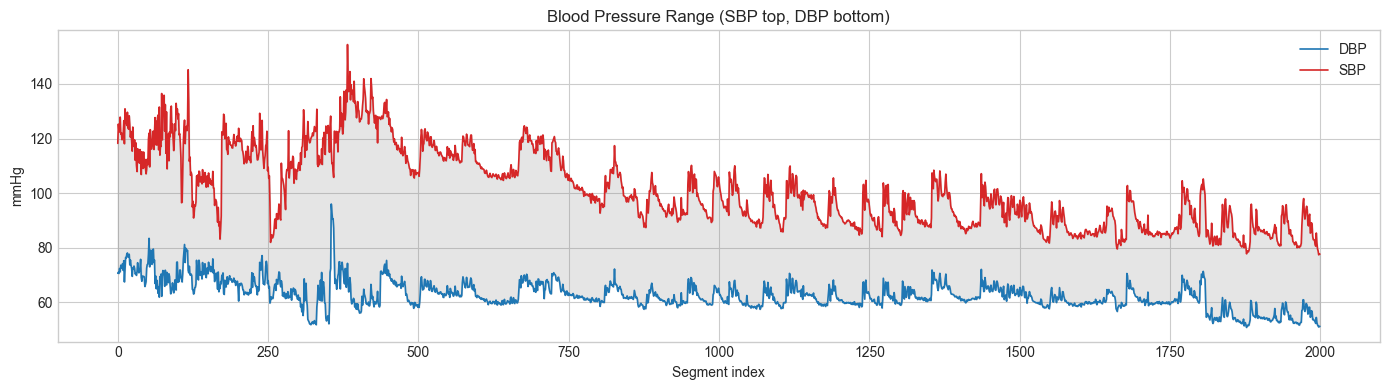

In [3]:
# 2) Load scalar table and plot BP range band (SBP top, DBP bottom)
cols = ['SubjectID','SegmentID','WinID','WinSeqID','Age','Gender','IncludeFlag','PPG_ABP_Corr','SegSBP','SegDBP']
df = extract_scalar_table('p008141.mat', cols)
for c in ['SegSBP','SegDBP','Age','PPG_ABP_Corr']:
    df[c] = pd.to_numeric(df[c], errors='coerce')
df['IncludeFlag'] = pd.to_numeric(df['IncludeFlag'], errors='coerce').astype('Int64')

sbp = df['SegSBP'].to_numpy(dtype=float)
dbp = df['SegDBP'].to_numpy(dtype=float)
mask = np.isfinite(sbp) & np.isfinite(dbp)
sbp = sbp[mask]; dbp = dbp[mask]
sbp = sbp[(sbp >= 60) & (sbp <= 240)]
dbp = dbp[(dbp >= 30) & (dbp <= 150)]
n = min(len(sbp), len(dbp))
if n > 0:
    max_n = min(n, 2000)
    x = np.arange(max_n)
    sbp_s = sbp[:max_n]
    dbp_s = dbp[:max_n]
    plt.figure(figsize=(14,4))
    plt.plot(x, dbp_s, color='#1f77b4', linewidth=1.2, label='DBP')
    plt.plot(x, sbp_s, color='#d62728', linewidth=1.2, label='SBP')
    plt.fill_between(x, dbp_s, sbp_s, color='gray', alpha=0.2)
    plt.title('Blood Pressure Range (SBP top, DBP bottom)')
    plt.xlabel('Segment index'); plt.ylabel('mmHg')
    plt.legend(loc='best'); plt.tight_layout(); plt.show()
else:
    plt.figure(); plt.text(0.5,0.5,'No valid SBP/DBP after filter',ha='center',va='center'); plt.axis('off'); plt.show()


## 3) PPG+ECG 1D CNN regression (5 folds, 400/300/50/50)

In [4]:
# Prepare two-channel inputs: PPG_Raw + ECG_Raw
ppg = extract_waveform_matrix('p008141.mat', 'PPG_Raw')
ecg = extract_waveform_matrix('p008141.mat', 'ECG_Raw')
targets = df[['SegSBP','SegDBP']].to_numpy(dtype=np.float32)
flags = df['IncludeFlag'].fillna(0).to_numpy()
mask = (flags == 1) & np.isfinite(targets).all(axis=1)
# 추가 품질 필터: 너무 낮은 분산(거의 평탄)인 세그먼트 제외
ppg_std = ppg.std(axis=1); ecg_std = ecg.std(axis=1)
mask = mask & (ppg_std > 1e-6) & (ecg_std > 1e-6)
ppg = ppg[mask]; ecg = ecg[mask]; targets = targets[mask]

# Stack channels -> (N, 2, L)
if ppg.shape[0] != ecg.shape[0] or ppg.shape[1] != ecg.shape[1]:
    raise ValueError(f'PPG/ECG shape mismatch: {ppg.shape} vs {ecg.shape}')
features = np.stack([ppg, ecg], axis=1).astype(np.float32)
N, C, L = features.shape
print('Features:', features.shape, 'Targets:', targets.shape)

FOLD_SIZE = 400; NUM_FOLDS = 5
required = NUM_FOLDS * FOLD_SIZE
if N < required:
    raise RuntimeError(f'Not enough quality segments: {N} (need \u2265 {required})')
# use the last block of segments so training folds leverage the stable tail
start_idx = N - required
features = features[start_idx:]
targets = targets[start_idx:]
N = features.shape[0]


Features: (2770, 2, 1250) Targets: (2770, 2)


In [5]:
# Model and training utilities
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

class TensorDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.as_tensor(x, dtype=torch.float32)
        self.y = torch.as_tensor(y, dtype=torch.float32)
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

class BPRegressorDualBranch(nn.Module):
    def __init__(self):
        super().__init__()
        # PPG branch
        self.ppg = nn.Sequential(
            nn.Conv1d(1, 16, 7, padding=3), nn.BatchNorm1d(16), nn.ReLU(), nn.MaxPool1d(2),
            nn.Conv1d(16, 32, 7, padding=3), nn.BatchNorm1d(32), nn.ReLU(), nn.MaxPool1d(2),
            nn.Conv1d(32, 64, 7, padding=3), nn.BatchNorm1d(64), nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        # ECG branch (조금 더 날카로운 커널도 고려 가능)
        self.ecg = nn.Sequential(
            nn.Conv1d(1, 16, 5, padding=2), nn.BatchNorm1d(16), nn.ReLU(), nn.MaxPool1d(2),
            nn.Conv1d(16, 32, 5, padding=2), nn.BatchNorm1d(32), nn.ReLU(), nn.MaxPool1d(2),
            nn.Conv1d(32, 64, 5, padding=2), nn.BatchNorm1d(64), nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*2, 128), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(128, 2)
        )
    def forward(self, x):
        # x: (N,2,L) -> split channels
        x_ppg = x[:,0:1,:]
        x_ecg = x[:,1:2,:]
        h1 = self.ppg(x_ppg)
        h2 = self.ecg(x_ecg)
        h = torch.cat([h1, h2], dim=1)
        return self.head(h)

def compute_metrics(y_true, y_pred):
    with torch.no_grad():
        err = y_pred - y_true
        mse = (err**2).mean(dim=0)
        rmse = torch.sqrt(mse)
        mae = err.abs().mean(dim=0)
        return mae.cpu().numpy(), rmse.cpu().numpy()

def normalize_channelwise(x_train, *others):
    mean = x_train.mean(axis=(0,2), keepdims=True)
    std = x_train.std(axis=(0,2), keepdims=True) + 1e-6
    outs = [ (arr-mean)/std for arr in others ]
    return (x_train-mean)/std, outs, mean, std

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS = 30; BATCH_SIZE = 64; LR = 5e-4; WEIGHT_DECAY = 1e-4; PATIENCE = 5
torch.manual_seed(42); np.random.seed(42)


In [6]:
# 5-fold training/evaluation (PPG+ECG)
fold_size = 400; train_size = 300; val_size = 50; test_size = 50; num_folds = 5
assert N >= num_folds*fold_size

per_fold = []
for k in range(num_folds):
    start = k*fold_size
    tr = slice(start, start+train_size)
    va = slice(start+train_size, start+train_size+val_size)
    te = slice(start+train_size+val_size, start+fold_size)

    x_tr = features[tr]; y_tr = targets[tr]
    x_va = features[va]; y_va = targets[va]
    x_te = features[te]; y_te = targets[te]

    x_tr_n, outs, mean, std = normalize_channelwise(x_tr, x_va, x_te)
    x_va_n, x_te_n = outs

    # Target standardization per fold
    y_mean = y_tr.mean(axis=0, keepdims=True); y_std = y_tr.std(axis=0, keepdims=True) + 1e-6
    y_tr_n = (y_tr - y_mean)/y_std; y_va_n = (y_va - y_mean)/y_std; y_te_n = (y_te - y_mean)/y_std

    dl_tr = DataLoader(TensorDataset(x_tr_n, y_tr_n), batch_size=BATCH_SIZE, shuffle=True)
    dl_va = DataLoader(TensorDataset(x_va_n, y_va_n), batch_size=BATCH_SIZE)
    dl_te = DataLoader(TensorDataset(x_te_n, y_te), batch_size=BATCH_SIZE)

    model = BPRegressorDualBranch().to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    crit = nn.MSELoss()

    best_val = float('inf'); best_state = None; patience = PATIENCE
    for epoch in range(EPOCHS):
        model.train()
        for xb, yb in dl_tr:
            xb = xb.to(DEVICE); yb = yb.to(DEVICE)
            opt.zero_grad(); pred = model(xb); loss = crit(pred, yb); loss.backward(); opt.step()
        model.eval(); val_loss = 0.0; nval = 0
        with torch.no_grad():
            for xb, yb in dl_va:
                xb = xb.to(DEVICE); yb = yb.to(DEVICE)
                l = crit(model(xb), yb).item(); val_loss += l*xb.size(0); nval += xb.size(0)
        val_loss /= max(1, nval)
        if val_loss < best_val:
            best_val = val_loss; best_state = {k:v.cpu().clone() for k,v in model.state_dict().items()}; patience = PATIENCE
        else:
            patience -= 1
            if patience == 0: break

    if best_state is not None: model.load_state_dict(best_state)

    # test
    model.eval(); y_true = []; y_pred = []
    with torch.no_grad():
        for xb, yb in dl_te:
            xb = xb.to(DEVICE); pred_n = model(xb).cpu()
            # denormalize back to mmHg
            pred = pred_n * torch.from_numpy(y_std).float() + torch.from_numpy(y_mean).float()
            y_true.append(yb); y_pred.append(pred)
    y_true = torch.cat(y_true, dim=0); y_pred = torch.cat(y_pred, dim=0)
    mae, rmse = compute_metrics(y_true, y_pred)
    print(f'Fold {k+1}: MAE(SBP)={mae[0]:.3f}, MAE(DBP)={mae[1]:.3f}, RMSE(SBP)={rmse[0]:.3f}, RMSE(DBP)={rmse[1]:.3f}')
    per_fold.append({'mae_sbp':mae[0], 'mae_dbp':mae[1], 'rmse_sbp':rmse[0], 'rmse_dbp':rmse[1]})

# summary
mae_sbp = np.array([d['mae_sbp'] for d in per_fold]); mae_dbp = np.array([d['mae_dbp'] for d in per_fold])
rmse_sbp = np.array([d['rmse_sbp'] for d in per_fold]); rmse_dbp = np.array([d['rmse_dbp'] for d in per_fold])
print('-'*60)
print(f'MAE(SBP): mean={mae_sbp.mean():.3f} std={mae_sbp.std(ddof=1):.3f}')
print(f'MAE(DBP): mean={mae_dbp.mean():.3f} std={mae_dbp.std(ddof=1):.3f}')
print(f'RMSE(SBP): mean={rmse_sbp.mean():.3f} std={rmse_sbp.std(ddof=1):.3f}')
print(f'RMSE(DBP): mean={rmse_dbp.mean():.3f} std={rmse_dbp.std(ddof=1):.3f}')
avg_mae = (mae_sbp + mae_dbp)/2; avg_rmse = (rmse_sbp + rmse_dbp)/2
print(f'Avg MAE: mean={avg_mae.mean():.3f} std={avg_mae.std(ddof=1):.3f}')
print(f'Avg RMSE: mean={avg_rmse.mean():.3f} std={avg_rmse.std(ddof=1):.3f}')


Fold 1: MAE(SBP)=3.438, MAE(DBP)=2.122, RMSE(SBP)=4.286, RMSE(DBP)=2.675
Fold 2: MAE(SBP)=5.688, MAE(DBP)=2.592, RMSE(SBP)=6.604, RMSE(DBP)=2.920
Fold 3: MAE(SBP)=4.356, MAE(DBP)=4.206, RMSE(SBP)=4.958, RMSE(DBP)=4.691
Fold 4: MAE(SBP)=5.229, MAE(DBP)=2.911, RMSE(SBP)=5.753, RMSE(DBP)=3.167
Fold 5: MAE(SBP)=4.956, MAE(DBP)=3.057, RMSE(SBP)=5.616, RMSE(DBP)=3.530
------------------------------------------------------------
MAE(SBP): mean=4.733 std=0.870
MAE(DBP): mean=2.978 std=0.775
RMSE(SBP): mean=5.444 std=0.873
RMSE(DBP): mean=3.397 std=0.789
Avg MAE: mean=3.855 std=0.610
Avg RMSE: mean=4.420 std=0.545
